In [17]:
import pandas as pd
import numpy as np
import os
import xarray as xr
import rasterio
from glob import glob
import geopandas as gpd

#path_fire = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\algeria_tunisia.csv"
#df_fire = pd.read_csv(path_fire)
df_fire_clean = pd.read_parquet(r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\local_dataset\dataset\fire_full.parquet", engine="fastparquet")

#df_fire_clean = df_fire[['longitude', 'latitude', 'type']].copy()

print(df_fire_clean.head())

        lon       lat  fire
0   9.48947  31.49290     1
1   9.49053  31.49524     1
2   9.49368  31.49449     1
3   9.49154  31.49420     1
4  10.09115  36.93407     1


In [18]:
print(f"Nombre de lignes dans df_fire_clean : {len(df_fire_clean)}")
print(f"Shape du dataset : {df_fire_clean.shape}")

Nombre de lignes dans df_fire_clean : 56864
Shape du dataset : (56864, 3)


In [19]:
# Créer l'attribut binaire 'fire'
# Si 'type' == 0, 'fire' = 1, sinon 'fire' = 0
"""df_fire_clean['fire'] = np.where(df_fire_clean['type'] == 0, 1, 0)

print(f"df_fire_clean avec colonne 'fire' créé : {df_fire_clean.shape}")
print(df_fire_clean.head())"""

'df_fire_clean[\'fire\'] = np.where(df_fire_clean[\'type\'] == 0, 1, 0)\n\nprint(f"df_fire_clean avec colonne \'fire\' créé : {df_fire_clean.shape}")\nprint(df_fire_clean.head())'

## Chargement et agrégation des données climatiques par saisons + Conversion en DataFrame

In [20]:
climate_csv_path = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\climat_clean.csv"
climate_df = pd.read_csv(climate_csv_path)

print("CSV climat chargé :", climate_df.shape)

# Convertir la date
climate_df["time"] = pd.to_datetime(climate_df["time"])

seasons_indices = {
    's1': [12, 1, 2],   # Hiver (Dec-Jan-Feb)
    's2': [3, 4, 5],    # Printemps
    's3': [6, 7, 8],    # Été
    's4': [9, 10, 11]   # Automne
}

# Ajouter colonne "season"

def get_season(date):
    m = date.month
    if m in [12, 1, 2]:
        return "s1"
    if m in [3, 4, 5]:
        return "s2"
    if m in [6, 7, 8]:
        return "s3"
    return "s4"

climate_df["season"] = climate_df["time"].apply(get_season)

all_dfs = []

variables = ["log_precip",  "tmax","amplitude_thermique"]

for var in variables:
    print(f"\nTraitement de la variable : {var}")

    for season in ["s1", "s2", "s3", "s4"]:
        
        df_season = climate_df[climate_df["season"] == season]

        if df_season.empty:
            print(f"   Saison {season} vide pour {var}")
            continue

        # Agrégation
        if var == "log_precip":
            df_agg = (
                df_season.groupby(["longitude", "latitude"])[var]
                .sum()
                .reset_index()
                .rename(columns={var: f"{var}_{season}"})
            )
        else:
            df_agg = (
                df_season.groupby(["longitude", "latitude"])[var]
                .mean()
                .reset_index()
                .rename(columns={var: f"{var}_{season}"})
            )

        all_dfs.append(df_agg)

        print(f"  → {var}_{season} agrégé ({df_agg.shape[0]} points)")


print("\n Toutes les variables saisonnières climatiques ont été générées.")

CSV climat chargé : (148292, 6)

Traitement de la variable : log_precip
  → log_precip_s1 agrégé (20301 points)
  → log_precip_s2 agrégé (20231 points)
  → log_precip_s3 agrégé (16200 points)
  → log_precip_s4 agrégé (21540 points)

Traitement de la variable : tmax
  → tmax_s1 agrégé (20301 points)
  → tmax_s2 agrégé (20231 points)
  → tmax_s3 agrégé (16200 points)
  → tmax_s4 agrégé (21540 points)

Traitement de la variable : amplitude_thermique
  → amplitude_thermique_s1 agrégé (20301 points)
  → amplitude_thermique_s2 agrégé (20231 points)
  → amplitude_thermique_s3 agrégé (16200 points)
  → amplitude_thermique_s4 agrégé (21540 points)

 Toutes les variables saisonnières climatiques ont été générées.


## Fusion des DataFrames climatiques en un seul DataFrame

In [21]:
# Commencer avec le premier DataFrame
df_climat_merged = all_dfs[0]

# Fusionner tous les autres DataFrames sur longitude et latitude
for i, df in enumerate(all_dfs[1:], 1):
    df_climat_merged = pd.merge(df_climat_merged, df, on=['longitude', 'latitude'], how='inner')
    print(f"   → Fusion {i}/{len(all_dfs)-1} terminée")

print(f"\n DataFrame climatique fusionné créé : {df_climat_merged.shape}")
print(f" Colonnes : {list(df_climat_merged.columns)}")
print("\n Aperçu :")
print(df_climat_merged.head())

   → Fusion 1/11 terminée
   → Fusion 2/11 terminée
   → Fusion 3/11 terminée
   → Fusion 4/11 terminée
   → Fusion 5/11 terminée
   → Fusion 6/11 terminée
   → Fusion 7/11 terminée
   → Fusion 8/11 terminée
   → Fusion 9/11 terminée
   → Fusion 10/11 terminée
   → Fusion 11/11 terminée

 DataFrame climatique fusionné créé : (10113, 14)
 Colonnes : ['longitude', 'latitude', 'log_precip_s1', 'log_precip_s2', 'log_precip_s3', 'log_precip_s4', 'tmax_s1', 'tmax_s2', 'tmax_s3', 'tmax_s4', 'amplitude_thermique_s1', 'amplitude_thermique_s2', 'amplitude_thermique_s3', 'amplitude_thermique_s4']

 Aperçu :
   longitude   latitude  log_precip_s1  log_precip_s2  log_precip_s3  \
0     -8.625  27.291667       3.082025       0.916291       0.832909   
1     -8.625  27.375000       3.224341       0.916291       1.964311   
2     -8.625  27.458333       3.655782       1.321756       1.996060   
3     -8.625  27.541667       3.654403       1.267652       1.163151   
4     -8.625  27.625000       2.0149

## Merge final : Fire + Climat (approche optimisée avec pd.merge)

In [22]:
# Arrondir les coordonnées à la résolution de la grille climatique
# La grille climatique a un pas de 0.083333° (= 1/12°)
# On arrondit donc à 1 décimale après avoir divisé par 0.083333

resolution = 1/12  # 0.083333°

# Fonction d'arrondissement à la grille la plus proche
def round_to_grid(value, resolution):
    return np.round(value / resolution) * resolution

# Créer des copies avec coordonnées arrondies
df_fire_rounded = df_fire_clean.copy()
df_fire_rounded['lon'] = round_to_grid(df_fire_clean['lon'], resolution)
df_fire_rounded['lat'] = round_to_grid(df_fire_clean['lat'], resolution)

df_climat_rounded = df_climat_merged.copy()
df_climat_rounded['longitude'] = round_to_grid(df_climat_merged['longitude'], resolution)
df_climat_rounded['latitude'] = round_to_grid(df_climat_merged['latitude'], resolution)


print(f"   Avant : lon={df_fire_clean['lon'].iloc[0]:.6f}, lat={df_fire_clean['lat'].iloc[0]:.6f}")
print(f"   Après : lon={df_fire_rounded['lon'].iloc[0]:.6f}, lat={df_fire_rounded['lat'].iloc[0]:.6f}")

# Merge avec les coordonnées arrondies
df_final = pd.merge(
    df_fire_clean,  # Garder les coordonnées originales du feu
    df_climat_rounded,
    left_on=[df_fire_rounded['lon'], df_fire_rounded['lat']],
    right_on=['longitude', 'latitude'],
    how='left',
    suffixes=('', '_y')
)

# Supprimer les colonnes longitude et latitude (du dataset climatique)
cols_to_drop = ['longitude', 'latitude']
if all(col in df_final.columns for col in cols_to_drop):
    df_final = df_final.drop(columns=cols_to_drop)
    print(f" Colonnes supprimées : {cols_to_drop}")

# Renommer key_0 et key_1 en longitude et latitude
if 'key_0' in df_final.columns and 'key_1' in df_final.columns:
    df_final = df_final.rename(columns={'key_0': 'lon', 'key_1': 'lat'})

print(f"\n Dataset final : {df_final.shape}")
print(f" Colonnes : {list(df_final.columns)}")
print("\n Aperçu :")
print(df_final.head())

   Avant : lon=9.489470, lat=31.492900
   Après : lon=9.500000, lat=31.500000
 Colonnes supprimées : ['longitude', 'latitude']

 Dataset final : (60463, 15)
 Colonnes : ['lon', 'lat', 'fire', 'log_precip_s1', 'log_precip_s2', 'log_precip_s3', 'log_precip_s4', 'tmax_s1', 'tmax_s2', 'tmax_s3', 'tmax_s4', 'amplitude_thermique_s1', 'amplitude_thermique_s2', 'amplitude_thermique_s3', 'amplitude_thermique_s4']

 Aperçu :
        lon       lat  fire  log_precip_s1  log_precip_s2  log_precip_s3  \
0   9.48947  31.49290     1            NaN            NaN            NaN   
1   9.49053  31.49524     1            NaN            NaN            NaN   
2   9.49368  31.49449     1            NaN            NaN            NaN   
3   9.49154  31.49420     1            NaN            NaN            NaN   
4  10.09115  36.93407     1      11.380727       6.419073        4.40628   

   log_precip_s4    tmax_s1  tmax_s2    tmax_s3  tmax_s4  \
0            NaN        NaN      NaN        NaN      NaN   
1   

## Land Cover - Spatial Join (sans centroïdes)

In [23]:
# Charger landcover avec les polygones originaux
gdf_land = gpd.read_file(r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\landcover_final_ML.gpkg")

print(f"Land cover chargé : {gdf_land.shape[0]} polygones")
print(f"CRS : {gdf_land.crs}")
print(f"Colonnes : {list(gdf_land.columns)}")

Land cover chargé : 307385 polygones
CRS : EPSG:4326
Colonnes : ['GRIDCODE', 'pays', 'log_area_sqm', 'lcc_code_encoded', 'geometry']


In [24]:
# Convertir df_final en GeoDataFrame avec des points géométriques
gdf_final = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final['lon'], df_final['lat']),
    crs="EPSG:4326"  # WGS84 (système de coordonnées standard)
)

print(f"\nGeoDataFrame créé : {gdf_final.shape}")
print(f"CRS : {gdf_final.crs}")
print(f"Type de géométrie : {gdf_final.geometry.geom_type.unique()}")


GeoDataFrame créé : (60463, 16)
CRS : EPSG:4326
Type de géométrie : ['Point']


In [25]:
# Aligner les systèmes de coordonnées si nécessaire
if gdf_final.crs != gdf_land.crs:
    print(f"\nReprojection de gdf_land : {gdf_land.crs} → {gdf_final.crs}")
    gdf_land = gdf_land.to_crs(gdf_final.crs)
else:
    print(f"\nLes CRS sont déjà alignés : {gdf_final.crs}")


Les CRS sont déjà alignés : EPSG:4326


In [26]:
# Spatial Join : Vérifier si chaque point est dans un polygone
print("\n Spatial Join en cours...")
gdf_full = gpd.sjoin(
    gdf_final,                    # Points (fire + climat)
    gdf_land[['geometry', 'GRIDCODE', 'log_area_sqm', 'lcc_code_encoded']],  # Polygones (land cover)
    how="left",                   # Garder tous les points même sans correspondance
    predicate="within"            # Test : le point est-il À L'INTÉRIEUR du polygone ?
)

print(f"\n Spatial Join terminé : {gdf_full.shape}")
print(f" Colonnes : {list(gdf_full.columns)}")


 Spatial Join en cours...

 Spatial Join terminé : (60463, 20)
 Colonnes : ['lon', 'lat', 'fire', 'log_precip_s1', 'log_precip_s2', 'log_precip_s3', 'log_precip_s4', 'tmax_s1', 'tmax_s2', 'tmax_s3', 'tmax_s4', 'amplitude_thermique_s1', 'amplitude_thermique_s2', 'amplitude_thermique_s3', 'amplitude_thermique_s4', 'geometry', 'index_right', 'GRIDCODE', 'log_area_sqm', 'lcc_code_encoded']


In [27]:
# Nettoyage : supprimer les colonnes inutiles et convertir en DataFrame
df_full = gdf_full.drop(columns=['geometry', 'index_right'], errors='ignore')

# Convertir en DataFrame pandas classique
df_full = pd.DataFrame(df_full)

print(f"\n Dataset final nettoyé : {df_full.shape}")
print(f" Colonnes : {list(df_full.columns)}")

# Vérifier combien de points ont trouvé une correspondance land cover
land_cover_matches = df_full['GRIDCODE'].notna().sum()
total_points = len(df_full)
print(f"\n Points avec land cover : {land_cover_matches}/{total_points} ({land_cover_matches/total_points*100:.1f}%)")


 Dataset final nettoyé : (60463, 18)
 Colonnes : ['lon', 'lat', 'fire', 'log_precip_s1', 'log_precip_s2', 'log_precip_s3', 'log_precip_s4', 'tmax_s1', 'tmax_s2', 'tmax_s3', 'tmax_s4', 'amplitude_thermique_s1', 'amplitude_thermique_s2', 'amplitude_thermique_s3', 'amplitude_thermique_s4', 'GRIDCODE', 'log_area_sqm', 'lcc_code_encoded']

 Points avec land cover : 7495/60463 (12.4%)


In [28]:
print("\n" + "="*70)
print(" DATASET FINAL - RÉSUMÉ")
print("="*70)
print(f"Shape : {df_full.shape}")
print(f"\nPremières lignes :")
print(df_full.head())
print(f"\nTypes de données :")
print(df_full.dtypes)
print(f"\nValeurs manquantes :")
print(df_full.isnull().sum())


 DATASET FINAL - RÉSUMÉ
Shape : (60463, 18)

Premières lignes :
        lon       lat  fire  log_precip_s1  log_precip_s2  log_precip_s3  \
0   9.48947  31.49290     1            NaN            NaN            NaN   
1   9.49053  31.49524     1            NaN            NaN            NaN   
2   9.49368  31.49449     1            NaN            NaN            NaN   
3   9.49154  31.49420     1            NaN            NaN            NaN   
4  10.09115  36.93407     1      11.380727       6.419073        4.40628   

   log_precip_s4    tmax_s1  tmax_s2    tmax_s3  tmax_s4  \
0            NaN        NaN      NaN        NaN      NaN   
1            NaN        NaN      NaN        NaN      NaN   
2            NaN        NaN      NaN        NaN      NaN   
3            NaN        NaN      NaN        NaN      NaN   
4      10.856232  17.666667    21.75  34.833333     28.0   

   amplitude_thermique_s1  amplitude_thermique_s2  amplitude_thermique_s3  \
0                     NaN               

C:\Users\anfel\AppData\Local\Temp\ipykernel_9676\19421036.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


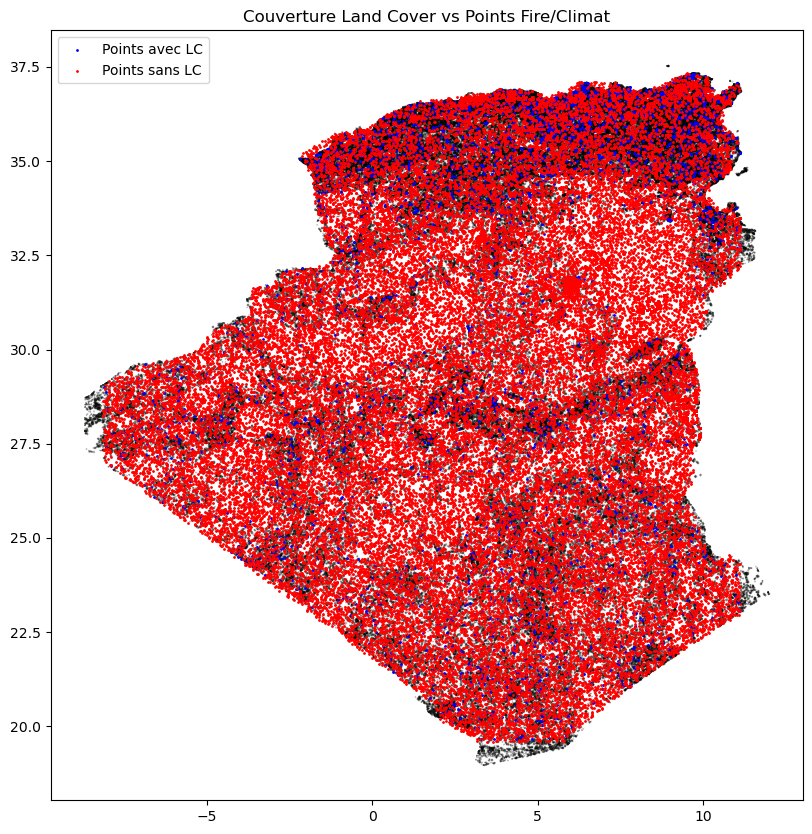

In [29]:
# Dans une nouvelle cellule, ajoutez :
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

# Tracer les polygones land cover
gdf_land.plot(ax=ax, color='lightgreen', edgecolor='black', alpha=0.5, label='Land Cover')

# Tracer les points qui ONT trouvé un match
gdf_final[df_full['GRIDCODE'].notna()].plot(ax=ax, color='blue', markersize=1, label='Points avec LC')

# Tracer les points qui N'ont PAS trouvé de match
gdf_final[df_full['GRIDCODE'].isna()].plot(ax=ax, color='red', markersize=1, label='Points sans LC')

plt.legend()
plt.title('Couverture Land Cover vs Points Fire/Climat')
plt.show()

In [30]:
output_path_final = "../local_dataset/dataset/merged.parquet"

df_full.to_parquet(output_path_final, index=False)
